In [1]:
import numpy
import keras
from matplotlib import pyplot
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.utils import to_categorical
from keras.models import load_model
%matplotlib inline

Using TensorFlow backend.


In [2]:
# load the dataset
dataframe = read_csv('intecleaned-correct.csv',usecols=[1,2,4,5,6,7,8,9], engine='python')
dataset = dataframe.values
# 将整型变为float
dataset = dataset.astype('float32')
dataframe.head()

,短期预测功率,短期预测湿度,短期预测风向,短期预测温度,短期预测气压,实际功率,实际风速,短期预测风速
0,34.41,75,41,14.7,1008,28.59,8.50,8.864167
1,33.71,75,40,14.7,1008,29.80,8.75,8.764167
2,33.01,75,39,14.6,1008,23.80,7.78,8.664167
3,32.32,75,38,14.5,1008,23.63,7.89,8.564167
4,31.66,75,38,14.5,1008,26.98,7.69,8.464167


In [3]:
# convert an array of values into a dataset matrix
# convert an array of values into a dataset matrix
#def create_traindataset(dataset, look_back,look_lag):
#    dataX, dataY = [], []
#    for i in range(0,len(dataset)-look_back-look_lag+1,1):
#        a = dataset[i:(i+look_back), :]
#        dataX.append(a)
#        b = dataset[(i+look_back):(i+look_back+look_lag),1]
#       dataY.append(b)
#    return numpy.array(dataX), numpy.array(dataY)
def create_dataset(dataset, look_back,look_lag):
    dataX, dataY = [], []
    for i in range(0,len(dataset)-look_back-look_lag+1,look_lag):
        a = dataset[i:(i+look_back), 1:]#前一天的短期预测湿度、短期预测风向、短期预测温度、
                                        #短期预测气压、实际功率、实际风速、短期预测风速都作为输入特征（共7个）
        c = dataset[(i+look_back):(i+look_back+look_lag),1:5]#当天的短期预测湿度、短期预测风向、短期预测温度、短期预测气压作为特征
        d = dataset[(i+look_back):(i+look_back+look_lag),7:8]#当天短期预测风速作为特征
        e = numpy.hstack([a,c])
        e = numpy.hstack([d,e])#把上面的特征都合在一起，共12个特征
        dataX.append(e)
        b = dataset[(i+look_back):(i+look_back+look_lag),5]#需要预测的功率数据
        dataY.append(b)
    return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)

# normalize the dataset
scaler_y = MinMaxScaler(feature_range=(0, 1))
Y = scaler_y.fit_transform(dataset[:,5:6])#把功率数据归一化

scaler = MinMaxScaler(feature_range=(0, 1))#把所有数据归一化
dataset = scaler.fit_transform(dataset)

In [4]:
look_back = 16 
look_lag = 16 #用前16个数据预测当前16个数据
train_size = 364*96
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size-look_back:len(dataset),:]
trainX, trainY = create_dataset(train, look_back,look_lag)
testX, testY = create_dataset(test, look_back,look_lag)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], look_back, 12))
testX = numpy.reshape(testX, (testX.shape[0], look_back,12))

In [5]:
testY.shape

(540, 16)

In [6]:
batch_size = 64
model = Sequential() 
model.add(LSTM(units=48, return_sequences=True, 
               input_shape=(trainX.shape[1],trainX.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(units=48, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=48,return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units = look_lag))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')  
model.fit(trainX, trainY, epochs = 200,batch_size = batch_size)

Epoch 1/200
2183/2183 [==============================] - 6s 3ms/step - loss: 0.0701
Epoch 2/200
2183/2183 [==============================] - 3s 1ms/step - loss: 0.0302
Epoch 3/200
2183/2183 [==============================] - 3s 2ms/step - loss: 0.0253
Epoch 4/200
2183/2183 [==============================] - 3s 1ms/step - loss: 0.0223
Epoch 5/200
2183/2183 [==============================] - 3s 1ms/step - loss: 0.0211
Epoch 6/200
2183/2183 [==============================] - 3s 1ms/step - loss: 0.0200
Epoch 7/200
2183/2183 [==============================] - 3s 1ms/step - loss: 0.0188
Epoch 8/200
2183/2183 [==============================] - 3s 2ms/step - loss: 0.0175
Epoch 9/200
2183/2183 [==============================] - 3s 1ms/step - loss: 0.0178
Epoch 10/200
2183/2183 [==============================] - 3s 1ms/step - loss: 0.0168
Epoch 11/200
2183/2183 [==============================] - 3s 1ms/step - loss: 0.0167
Epoch 12/200
2183/2183 [==============================] - 3s 1ms/step - lo

In [7]:
# 执行预测
testPredict = model.predict(testX)

In [8]:
testPredict.shape

(540, 16)

In [9]:
testPredict = testPredict.reshape(-1,1)
testPredict = scaler_y.inverse_transform(testPredict)

In [10]:
testPredict

array([[29.207146],
       [29.190104],
       [29.378803],
       ...,
       [37.697914],
       [37.6814  ],
       [37.443287]], dtype=float32)

In [11]:
testY = testY.reshape(-1,1)
testY = scaler_y.inverse_transform(testY)

In [12]:
testY.shape

(8640, 1)

In [13]:
def result(testY,testPredict):
    from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
    mse = mean_squared_error(testY,testPredict)
    mae = mean_absolute_error(testY,testPredict)
    r_square = r2_score(testY,testPredict)
    print("MSE:",mse)
    print("MAE:",mae)
    print("R_Square:",r_square)
    rmse = math.sqrt(mse)
    print("RMSE",rmse)
    capacity = 49.5
    print("NRMSE",1 - rmse/capacity)
    p_hme = 0
    whole_power = 49.5
    for l in range(testY.shape[0]):
        if testY[l] <= whole_power * 0.03 and testPredict[l] <= whole_power * 0.03:
             continue
        p_hme = p_hme + abs(testY[l] / (testY[l] +testPredict[l]) - 0.5) * abs(testPredict[l] - testY[l]) / numpy.sum(
        numpy.abs(testPredict - testY))
    p_hme =  1 - 2 * p_hme
    print("超短期预测准确率E:",p_hme)

In [14]:
predictions_1 = testPredict[0:31*96,0]
predictions_2 = testPredict[31*96:59*96,0]
predictions_3 = testPredict[59*96:90*96,0]

test_labels_1 = testY[0:31*96,0]
test_labels_2 = testY[31*96:59*96,0]
test_labels_3 = testY[59*96:90*96,0]

print("2019年1-3月结果：")
result(testY,testPredict)
print("2019年1月结果：")
result(test_labels_1,predictions_1)
print("2019年2月结果：")
result(test_labels_2,predictions_2)
print("2019年3月结果：")
result(test_labels_3,predictions_3)

2019年1-3月结果：
MSE: 27.519827
MAE: 3.6967883
R_Square: 0.8488706507867644
RMSE 5.245934319931778
NRMSE 0.8940215288902671
超短期预测准确率E: [0.7257266]
2019年1月结果：
MSE: 28.900354
MAE: 3.922877
R_Square: 0.823628889104312
RMSE 5.375904982919246
NRMSE 0.8913958589309243
超短期预测准确率E: 0.752409483005508
2019年2月结果：
MSE: 26.94072
MAE: 3.6140525
R_Square: 0.8557451021359515
RMSE 5.1904450295222455
NRMSE 0.8951425246561162
超短期预测准确率E: 0.7276108716936845
2019年3月结果：
MSE: 26.662367
MAE: 3.5454278
R_Square: 0.8568195081104427
RMSE 5.163561451853306
NRMSE 0.8956856272352868
超短期预测准确率E: 0.6944695667677758


In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 16, 48)            11712     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 48)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 16, 48)            18624     
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 48)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 48)                18624     
_________________________________________________________________
dropout_3 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                784       
Total para

In [16]:
testorin=dataframe.values[train_size:,0]
testorin=testorin.reshape(8640,1)
new_data = numpy.hstack([testY,testorin,testPredict])
import pandas as pd
new_data = pd.DataFrame(new_data,columns= ['实际功率','原系统预测功率','超短期预测功率'])
new_data.to_csv('LSTM-ushort-89.40-2020年4月26日-15：32.csv', index=False, sep=',')

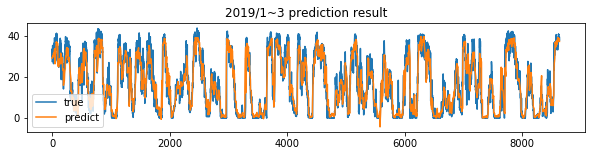

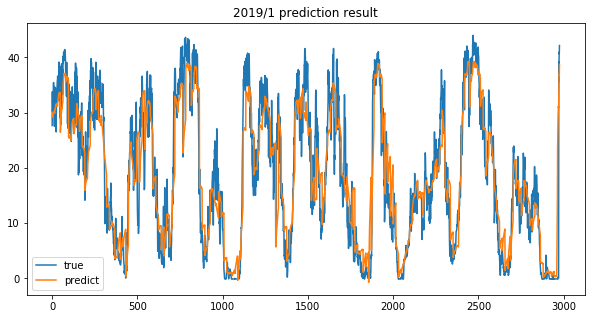

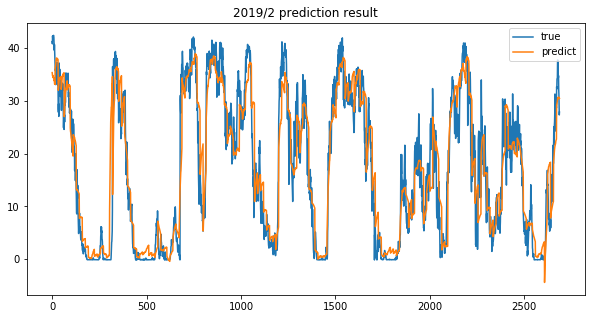

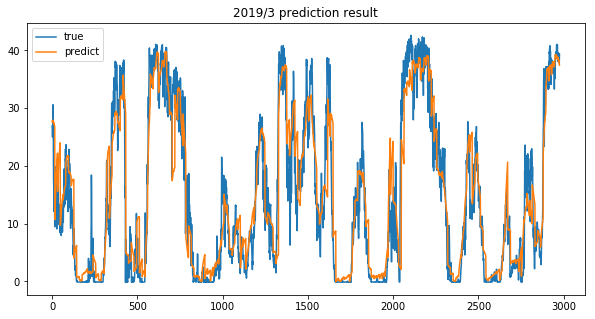

In [18]:
pyplot.figure(figsize=(10,2))
pyplot.plot(testY, label='true')
pyplot.plot(testPredict, label='predict')
pyplot.title('2019/1~3 prediction result')
pyplot.legend()
pyplot.show()

pyplot.figure(figsize=(10,5))
pyplot.plot(test_labels_1, label='true')
pyplot.plot(predictions_1, label='predict')
pyplot.title('2019/1 prediction result')
pyplot.legend()
pyplot.show()

pyplot.figure(figsize=(10,5))
pyplot.plot(test_labels_2, label='true')
pyplot.plot(predictions_2, label='predict')
pyplot.title('2019/2 prediction result')
pyplot.legend()
pyplot.show()

pyplot.figure(figsize=(10,5))
pyplot.plot(test_labels_3, label='true')
pyplot.plot(predictions_3, label='predict')
pyplot.title('2019/3 prediction result')
pyplot.legend()
pyplot.show()